# PySmorch: A  machine learning library for the dregs of society


Name: **Haitham Khedr**

UID:  **116098700**

After graduating with an advanced degree in CS, you apply for jobs. You get an interview at Facebook, but the HR team rejects your application when they find out you didn't get an 'A+' in 764.  Soon after, a recruiter for Friendster reaches out to you and offers you a job.  The pay is lousy and the cafeteria only serves Hot Pockets, but after your performance in 764, this is the best you can ever hope for in life.  You accept the job and come to terms with reality.

Ready, code monkey? Your first assignment is to implement a neural network classifier.  Company policy dictates that all data science work must be done using Friendster's proprietary ML framework, PySmorch.  To your horror, you discover that the developers of PySmorch forgot to implement the backward routines in any of the neural network layers. 

You realize there's only one way forward: complete the PySmorch library, implement a neural network classifier, become the CEO of Friendster, and raise the company to fame as the foremost social network!  So grab a club-mate and hunker down in your cube...it's time to go to war. 

...but first...let's configure your environment.

In [1]:
import notebook_importer
import utility
from math import sqrt
from scipy.signal import convolve2d
import numpy as np
from numpy.linalg import norm
from numpy.random import randn, normal, randint
from numpy import atleast_1d, flipud, fliplr
import urllib
import matplotlib.pyplot as plt
from hmwk3_grads import check_gradient
np.random.seed(0)
def good_job(path):
    a = plt.imread(urllib.request.urlopen(path))
    fig = plt.imshow(a)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

np.random.seed(0)

running importer
importing Jupyter notebook from utility.ipynb
Founds 2 cells
importing Jupyter notebook from hmwk3_grads.ipynb
Founds 28 cells
importing Jupyter notebook from hmwk2_more_linalg.ipynb
Founds 28 cells
Recovery error (clean) = 1.93e-06
measurement error = 1.79e-07
Recovery error (noisy) = 178.930
Max eigen values:1.695939e+00. Min eigen value:1.111539e-10
Condition Number:1.525758e+10
Max eigen values:1.705939e+00. Min eigen value:1.000000e-02
Condition Number:1.705939e+02
Recovery error (noisy) = 2.558
Adjoint Test Failed, rel_diff = 3040.026084495693
Adjoint Test Passed, rel_diff = 9.870008142872531e-11
Tests PASSED! You're on your way to understanding linear operators!
TESTS PASSED!  YOU ROCK!
Adjoint Test Passed, rel_diff = 1.2809491335957507e-14
Adjoint Test Passed, rel_diff = 2.1390168887322673e-14
Adjoint Test Passed, rel_diff = 2.5618982671915014e-14
Unit tests PASSED!  You're getting really good at this!
Horizontal error =  6.82436205048795e-13
Vertical error =  

Tests passed!  Your gradient checker is like totally awesome!


Test PASSED!  Your logistic loss works!


Tests passed!  Your logistic gradients are perfect!


Test PASSED!


PySmorch contains classes that implement different neural network components.  You create a network by layering these components together.

Lets start by defining a data input layer, which just stores an array.  During the forward pass, it just hands its data array forward to the next layer.  During the backward pass, it does nothing since it contains no variables.

Let's also define a least-squares loss.  It takes in $X$ and returns $\frac{1}{2M}\|X-Y\|^2$ where $Y$ is an array of labels specified when the loss in constructed, and $M$ is the number of training vectors (i.e, rows of $X$).  The backward pass computes the gradient of the loss with respect to the inputs ($X$), and recursively hands it back (i.e., "backprops") to the layer behind.

You don't have to modify the cell below - the PySmorch devs already wrote these classes. However understanding these methods will help you implement other missing methods.

In [2]:
# Don't modify this code block!
class Data:
    """Stores an input array of training data, and hands it to the next layer."""
    def __init__(self, data):  
        self.data = data
        self.out_dims = data.shape
    def set_data(self, data):
        self.data = data
    def forward(self):
        return self.data
    def backward(self, dwnstrm):
        pass

class SquareLoss:
    """Given a matrix of logits (one logit vector per row), and a vector labels, 
    compute the sum of squares difference between the two"""
    def __init__(self, in_layer, labels):
        self.in_layer = in_layer
        self.labels = labels
    def set_data(self, labels):
        self.labels[:] = labels
    def forward(self):
        """Loss value is (1/2M) || X-Y ||^2"""
        self.in_array = self.in_layer.forward()
        self.num_data = self.in_array.shape[0]
        return (0.5/self.num_data) * norm(self.in_array-self.labels)**2
    
    def backward(self):
        """Loss value is (1/M) (X-Y), where N is the number of training samples"""
        self.pass_back = (self.in_array-self.labels)/self.num_data
        self.in_layer.backward(self.pass_back) # hand the gradient of loss with respect to inputs back to previous layer


### You don't trust the PySmorth devs though...so run this unit test just to make sure.

In [3]:
# Create a random test problem 
X = Data(randn(10,3))
Y = randn(10,3)
# Create a square loss layer that accepts the X's, and compares them to the Y's.  
# This is basically a neural net that does nothing but compute a loss.
loss = SquareLoss(X,Y)
# Create functions to produce the loss, and its gradient
def network_loss(Xdata):
    X.set_data(Xdata)
    return loss.forward()
def loss_grad(Xdata):
    X.set_data(Xdata)
    loss.forward()
    loss.backward()
    return loss.pass_back
did_pass = check_gradient(network_loss,loss_grad,randn(10,3))
assert did_pass, "Your gradient checker is no good!"
print("TEST PASSED!  Guess the PySmorch devs don't screw up EVERYTHING.")

TEST PASSED!  Guess the PySmorch devs don't screw up EVERYTHING.


# Problem 1: A linear layer 
This layer takes its input $X,$ and produces $XW,$ where $W$ is a matrix of layer parameters.  The backward step does two things.  First, it computes the gradient of the downstream loss with respect to `W`.  It stores this gradient in an array called `self.G`.  Then, it computes the gradient of the downstream loss with respect to the input, and recursively hands this down to the layer beneath it. 

In [4]:
class Linear:
    """Given an input matrix X, with one feature vector per row, 
    this layer computes XW, where W is a linear operator."""
    def __init__(self, in_layer, num_out_features):
        assert len(in_layer.out_dims)==2, "Input layer must contain a list of 1D linear feature data."
        self.in_layer = in_layer
        num_data, num_in_features = in_layer.out_dims
        self.out_dims = np.array([num_data, num_out_features])
        # Declare the weight matrix
        self.W = randn(num_in_features, num_out_features)/sqrt(num_in_features)  
    def forward(self):
        """This function computes XW"""
        self.in_array = self.in_layer.forward()
        ##### YOUR CODE HERE #####
        return self.in_array @ self.W ##### YOUR CODE HERE #####
    def backward(self, dwnstrm):
        # Compute the gradient of the loss with respect to W, and store it as G
        self.G = self.in_array.T @ dwnstrm ##### YOUR CODE HERE #####
        # Compute grad of loss with respect to inputs, and hand this gradient backward to the layer behind
        input_grad = dwnstrm @ self.W.T ##### YOUR CODE HERE #####
        self.in_layer.backward(input_grad)

### Now run this unit test.  Don't change anything in this code block.

TEST PASSED!  Your linear layer is terrific


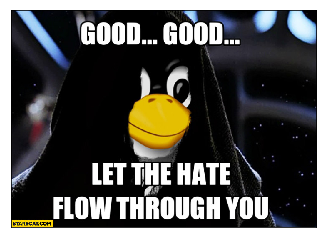

In [5]:
# Don't modify this code block!
# Make a random dataset with 10 samples of 3 features each
X = Data(randn(10,3))
Y = randn(10,2)            # The label vector has to entries per sample
L1 = Linear(X,num_out_features=4)  # A linear layer maps each 3-vector onto a 2-vector
L2 = Linear(L1,num_out_features=2)  # A linear layer maps each 3-vector onto a 2-vector
loss = SquareLoss(L2,Y)    # Loss compares the output of the linear layer to the labels
# Check the gradient for W
def network_loss(W): # Computes the value of the loss function
    L2.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L2_grad(W):      # Gradient of loss function with respect to weights in linear layer
    L2.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L2.G
W = normal(size=L2.W.shape)
did_pass = check_gradient(network_loss,L2_grad,W)
assert did_pass, "Your linear layer is no good!  You did not get the right gradient with respect to W."

# Check that the correct gradient is passed back
def network_loss(W): # Computes the value of the loss function
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):      # Gradient of loss function with respect to weights in linear layer
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Your linear layer is no good!  You did not pass back the correct gradient with respect to the layer inputs."

print("TEST PASSED!  Your linear layer is terrific")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/penguin_hate.png")

# Problem 2 - Relu non-linearity

Neural nets are no good without non-linearities.  If all the layers are linear operators, then the entire network can never be any more powerful than a single linear operator (why?).  Implement a Relu non-linearity.

In [6]:
class Relu:
    """Given an input matrix X, with one feature vector per row, 
    this layer computes maximum(X,0), where the maximum operator is coordinate-wise."""
    def __init__(self, in_layer):
        self.in_layer = in_layer
        self.in_dims = in_layer.out_dims
        self.out_dims = self.in_dims
    def forward(self):
        self.in_array = self.in_layer.forward()
        ##### YOUR CODE HERE #####
        return np.maximum(self.in_array,0)
    def backward(self, dwnstrm):
        ##### YOUR CODE HERE #####
        self.pass_back = np.zeros_like(self.in_array)
        self.pass_back[self.in_array  > 0] = 1.
        self.in_layer.backward(self.pass_back * dwnstrm)

### Now test your Relu

TEST PASSED!  Your Relu layer works


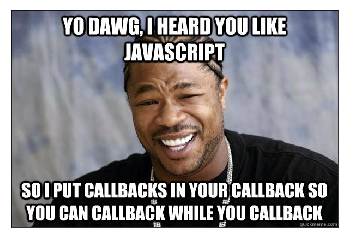

In [7]:
# Don't modify this code block!
# Create a dataset
X = Data(randn(10,3))
Y = randn(10,1)
# Create network with 2 linear layers and a Relu in the middle
L1 = Linear(X,5)
R1 = Relu(L1)
L2 = Linear(R1,1)
loss = SquareLoss(L2,Y)
# Methods to compute loss function, and gradient of loss with respect to L1 parameters.  This gradient has to
# backprop through your Relu, so this test should fail if your Relu is messed up.
def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Your gradient checker is no good!"
print("TEST PASSED!  Your Relu layer works")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/call_backs.png")

# Problem 3 - cross entropy
A real classification net uses a cross-entropy loss instead of a least-squares loss. Given an input/logit vector $x$ with class label $k,$ the cross entropy is given by 
  $$- \log\left(  \frac{\exp(x_k)} { \sum_i \exp(x_i) }   \right) = -x_k + \log( \sum_i \exp(x_i)).$$
You can use the `LeastSquares` loss class as a model for how to do this.  The formulas for forward and backward will be different though.

**Your implementation of this layer can never exponentiate a positive number!**


In [8]:
eps = 1e-10
class CrossEntropy:
    """Given a matrix of logits (one logit vector per row), and a vector labels, 
    compute the cross entropy of the softmax.
    The labels must be a 1d vector"""
    def __init__(self, in_layer, ones_hot):
        self.in_layer = in_layer
        self.ones_hot = ones_hot
    def set_labels(self, ones_hot):
        self.ones_hot = ones_hots
    def forward(self):
        in_array = self.in_layer.forward()
        c = np.max(in_array,axis = 1).reshape((-1,1)) # const used to prevent exp(+ve)
        log_prob = np.exp(in_array - c)
        nrmlz = np.sum(log_prob,axis = 1).reshape((-1,1))
        self.prob = log_prob / nrmlz
        return np.sum(-1*np.log(eps + np.sum(self.prob * self.ones_hot,axis = 1)))
    def backward(self):
        ##### YOUR CODE HERE #####
        self.pass_back = self.prob - self.ones_hot
        self.in_layer.backward(self.pass_back)

### Now, run this unit test for your cross-entropy layer

Checking the gradient...
    Passed
Checking that your method is stable with large inputs.
    Passed
TEST PASSED!  Your softmax layer isn't good...it's teeeerific!


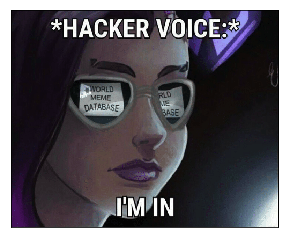

In [9]:
# Don't modify this code block!
## Make dataset
X = Data(randn(10,3))    # Create 10 random feature vectors of length 3
Y = randint(5,size=(10)) # Assign a random class to each vector
Y = np.eye(5)[Y]         # Convert the 1D label vector to a 2D one's hot encoding with a 5-entry row for each sample
# Build neural net with a linear layer, Relu, and a cross entropy loss
L1 = Linear(X,5)
R1 = Relu(L1)
loss = CrossEntropy(R1,Y)
# Build methods to get loss and gradient
def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
print('Checking the gradient...')
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Your softmax gradient is no good! Check your gradient formula!"
print('    Passed')
print('Checking that your method is stable with large inputs.')
L1.W = normal(size=L1.W.shape)*1000
l = loss.forward()
assert np.isfinite(l), "Your softmax gradient is unstable.  You probably exponentiated positive numbers.  That's not allowed!"
print('    Passed')
print("TEST PASSED!  Your softmax layer isn't good...it's teeeerific!")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/hacker_database.png")

# Problem 4 - bias
Right now each neuron computer a linear operator on the inputs (i.e., $xw$ for some input row vector $x$ and weight vector $w$).  In practice, we want to compute $xw+b$ for some constant b.  

Write a layer that takes in a feature map, and adds a (trainable) constant to each output. 

In [10]:
class Bias:
    """Given an input matrix X, add a trainable constant to each entry."""
    def __init__(self, in_layer):
        self.in_layer = in_layer
        num_data, num_in_features = in_layer.out_dims
        self.out_dims = in_layer.out_dims
        # Declare the weight matrix
        self.W = randn(1,num_in_features) 
    def forward(self):
        ##### YOUR CODE HERE #####
        in_array = self.in_layer.forward()
        return in_array + self.W
    
    def backward(self, dwnstrm):
        # Compute the gradient of the loss with respect to W, and store it as G
        self.G = np.sum(dwnstrm,axis = 0)
        # Compute grad of loss with respect to inputs, and hand this gradient backward to the layer behind
        self.in_layer.backward(dwnstrm)

### Your code is always perfect.  But there's all sorts of bugs in the Friendster codebase.  So better run this unit test to be sure...

TEST PASSED!  Your bias layer works


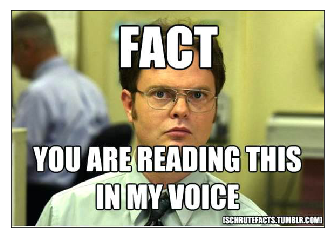

In [11]:
# Don't modify this code block!
# Create a dataset
X = Data(randn(10,3))
Y = randn(10,1)
# Create network with 2 linear layers and a Relu in the middle
L1 = Linear(X,5)
B1 = Bias(L1)
R1 = Relu(B1)
L2 = Linear(R1,1)
loss = SquareLoss(L2,Y)
# Build methods to get loss and gradient
def network_loss(W):
    B1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def B1_grad(W):
    B1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return B1.G
W = normal(size=B1.W.shape)
did_pass = check_gradient(network_loss,B1_grad,W)
assert did_pass, "Your bias gradient is no good.  You used the wrong formula for the gradient with respect to W!"
def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Your bias gradient is no good!  You passed back the wrong gradient with respect to layer inputs!"
print("TEST PASSED!  Your bias layer works")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/my_voice.png")

# Finally, test a complete net with 3 linear layers, relus, bias, and cross-entropy 

Wow!  You did it!  As your boss, I'm soooo impressed with you!  You're the best dev we're got here at
Friendster, and you've been promoted to CTO!  Stock value is up and we've got 14M new users!


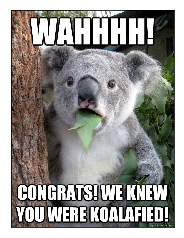

In [12]:
# Don't modify this code block!
## Make dataset
X = Data(randn(10,3))    # Create 10 random feature vectors of length 3
Y = randint(5,size=(10)) # Assign a random class to each vector
Y = np.eye(5)[Y]         # Convert the 1D label vector to a 2D one's hot encoding with a 5-entry row for each sample

# Create network with 3 linear layers, biases, and Relu
L1 = Linear(X,5)
B1 = Bias(L1)
R1 = Relu(B1)
L2 = Linear(R1,8)
B2 = Bias(L2)
R2 = Relu(B2)
L3 = Linear(R2,5)
B3 = Bias(L3)
loss = CrossEntropy(B3,Y)

def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value

def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Your network failed!  Run all the unit tests above and double check!"
print("""Wow!  You did it!  As your boss, I'm soooo impressed with you!  You're the best dev we're got here at
Friendster, and you've been promoted to CTO!  Stock value is up and we've got 14M new users!""")

good_job("https://www.cs.umd.edu/~tomg/img/important_memes/koala.png")
